<a href="https://colab.research.google.com/github/henriqueburis/segment-anything_meta/blob/main/segment_anything_meta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/facebookresearch/segment-anything.git

Cloning into 'segment-anything'...
remote: Enumerating objects: 284, done.
remote: Counting objects: 100% (284/284), done.
remote: Compressing objects: 100% (151/151), done.
remote: Total 284 (delta 142), reused 199 (delta 129), pack-reused 0
Receiving objects: 100% (284/284), 18.31 MiB | 11.12 MiB/s, done.
Resolving deltas: 100% (142/142), done.


In [2]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-_tfi42og
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-_tfi42og
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36610 sha256=72d2f50888c3a80bf422585b3cdd4d39d9c18064c9c03d21c4c87d636fef034f
  Stored in directory: /tmp/pip-ephem-wheel-cache-ghugf_09/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [22]:
!mkdir images
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
!wget -P images https://github.com/henriqueburis/segment-anything_meta/blob/main/figs/001pivos.png
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

mkdir: cannot create directory ‘images’: File exists
--2023-05-05 22:43:50--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99846 (98K) [image/jpeg]
Saving to: ‘images/dog.jpg.1’

dog.jpg.1           100%[===================>]  97.51K  --.-KB/s    in 0.002s  

2023-05-05 22:43:50 (60.7 MB/s) - ‘images/dog.jpg.1’ saved [99846/99846]

--2023-05-05 22:43:50--  https://github.com/henriqueburis/segment-anything_meta/blob/main/figs/001pivos.png
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘images/001

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [5]:
### Utils ###

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)  

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

In [6]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)


predictor = SamPredictor(sam)

mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)


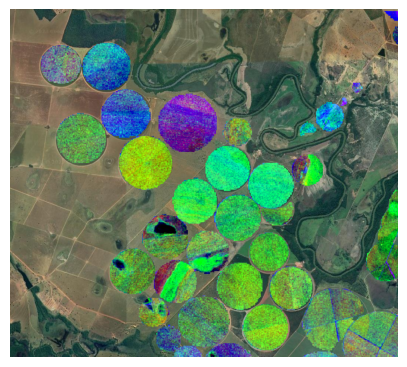

In [25]:
#image = cv2.imread('images/dog.jpg')
image = cv2.imread('images/001pivos.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(5,5))
plt.imshow(image)
plt.axis('off')
plt.show()

In [26]:
masks = mask_generator_2.generate(image)

In [48]:
import numpy as np
from skimage import measure

threshold = 0.5 # valor de limiar (opcional)
binary_mask = (masks[5]['segmentation'] > threshold).astype(np.uint8)

labels = measure.label(binary_mask)
print(labels)

bbox_list = []
for region in measure.regionprops(labels):
    bbox = region.bbox # retorna (min_row, min_col, max_row, max_col)
    bbox_list.append(bbox)
input_box = np.array(bbox_list[0])
print(input_box)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[490 315 597 424]


240
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


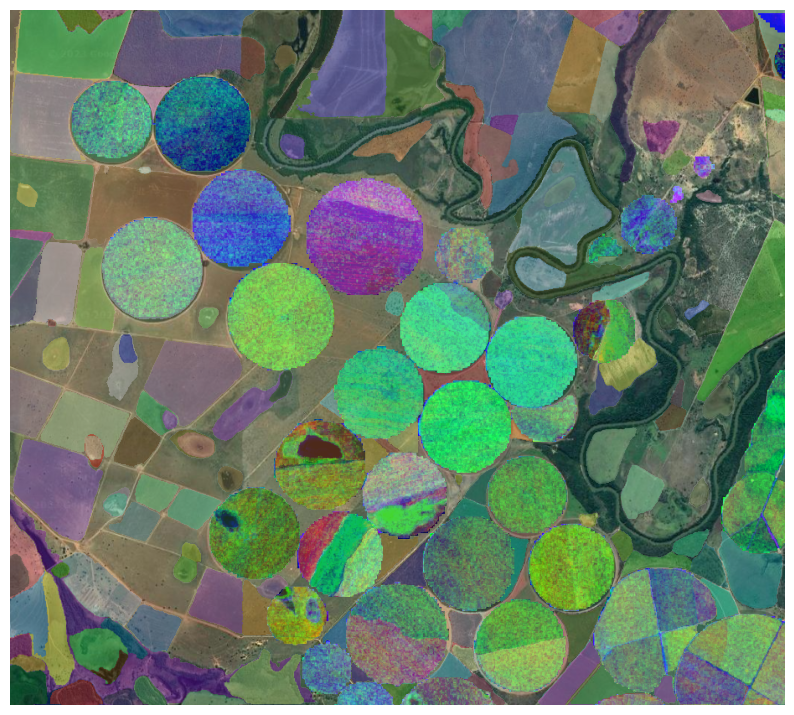

In [49]:
print(len(masks))
print(masks[0].keys())

plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

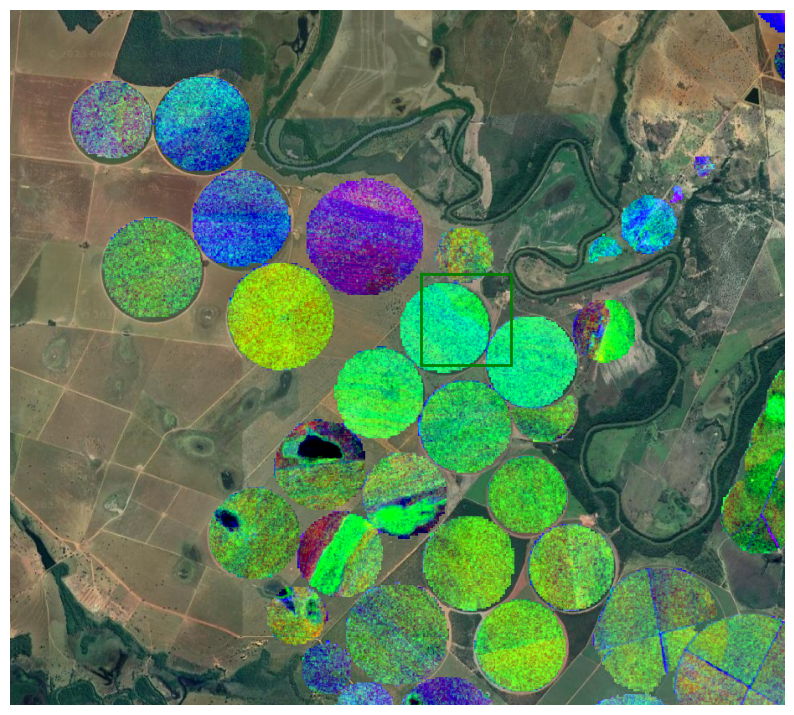

In [54]:
plt.figure(figsize=(10,10))
plt.imshow(image)
#show_anns(masks)
#show_mask(masks[k]['segmentation'], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show() 

Usando a mask gerada pelo SAM para preditor
Specifying a specific object with a box
The model can also take a box as input, provided in xyxy format.

In [51]:
predictor.set_image(image)

In [52]:
masks_pre, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

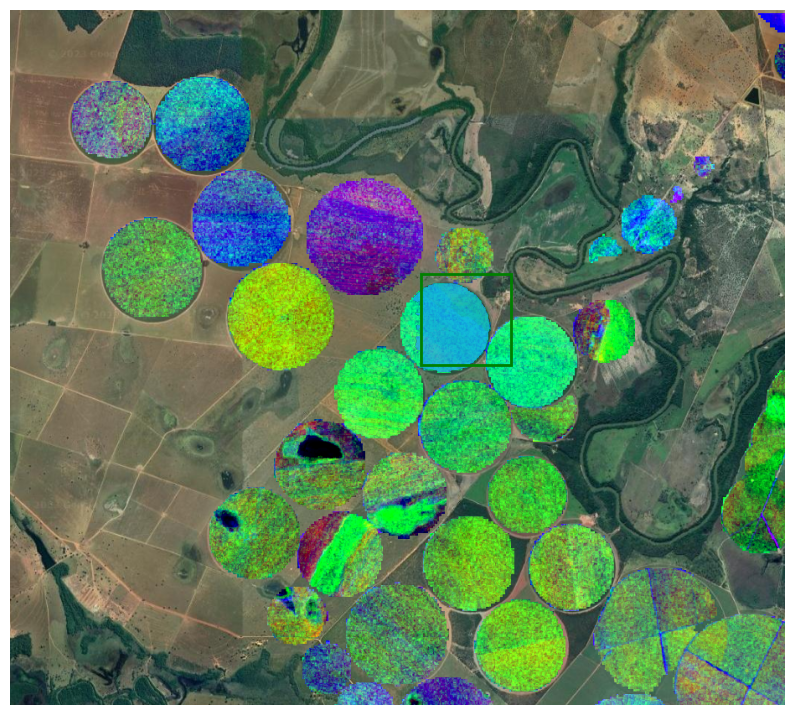

In [53]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks_pre[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()